In [2]:
# Core analysis packages
import numpy as np
import os, sys
import pandas as pd
from scipy import stats
from scipy.special import comb
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import anova
from patsy import dmatrices
import bff

import networkx as nx

# Plotting packages
import matplotlib.pyplot as plt; plt.rcdefaults()
import seaborn as sns 
sns.set(style="ticks", color_codes=True)
sns.set_style("white")
sns.set_style({'xtick.bottom': True, 'ytick.left': True})
colorref = ["gray", "royalblue", "crimson", "goldenrod", "mediumorchid", "seagreen"]

# iPython magic commands
%matplotlib notebook
%load_ext autoreload
%autoreload 2
%autosave 30

SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIG_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIG_SIZE)  # fontsize of the figure title
cust_palette = sns.color_palette("Paired")[6:10]
cust_palette = [cust_palette[i] for i in [1,0,3,2]]

def median_split(S):
    return S > S.median()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 30 seconds


In [3]:
# Load file (from same directory as the notebook)
df = pd.read_excel(os.path.expanduser("network.xlsx"), index_col=0)
df.head()

,CLUSTER,NETWORK,PARTICIPANT,CONDITION,DURATION,GENDER,AGE,AMERICAN,PARTY,TWITTERUSER,...,POST7,POST8,POST9,POST10,POST11,POST12,POST13,POST14,POST15,POST16
Response ID,,,,,,,,,,,,,,,,,,,,,
R_2xRSW7gQOO8Aenr,1,1,1,1,2140,1,19,0,3,1,...,20,67,41,65,26,19,35,65,37,79
R_1g5V0U7NatFob0x,1,1,2,1,2514,0,20,0,4,0,...,77,27,28,67,52,75,31,63,71,100
R_3iwBoUcO1237jF1,1,1,3,1,2428,1,19,1,1,0,...,61,88,71,36,30,35,39,94,66,68
R_1QoMZGGj8soR7JL,1,1,4,1,2365,0,20,1,1,0,...,44,60,55,47,75,45,45,54,55,67
R_3R2sjtnUIGMT7o5,1,1,5,1,2329,0,18,1,2,1,...,19,70,40,60,61,97,73,20,73,61


In [4]:
# Extract columns with df.target or df["target"] or df.loc[:,"target"]
age = df.loc[:, "AGE"]
party = df.loc[:, "PARTY"]
twitter = df.loc[:, "TWITTERUSER"]
trust = df.loc[:,"TRUSTSCIENCE"]
duration = df.loc[:,"DURATION"]
network = df.loc[:,"NETWORK"]
participant = df.loc[:,"PARTICIPANT"]

In [5]:
# Extract data with df.loc[:,"datastart":"dataend"]
RdeltaB = df.loc[:, "RU1":"RU16"]
convincing = df.loc[:, "C1":"C16"]
rigorous = df.loc[:, "R1":"R16"]
personal = df.loc[:, "P1":"P16"]
widespread = df.loc[:, "W1":"W16"]
share = df.loc[:, "S1":"S16"]
time = df.loc[:, "T1":"T16"]
selfM = df.loc[:, "selfM1":"selfM16"]
jointM = df.loc[:, "jointM1":"jointM16"]
partnerM = df.loc[:, "partnerM1":"partnerM16"]
selfB = df.loc[:, "selfB1":"selfB16"]
jointB = df.loc[:, "jointB1":"jointB16"]
partnerB = df.loc[:, "partnerB1":"partnerB16"]
pre = df.loc[:, "PRE1":"PRE16"]
post = df.loc[:, "POST1":"POST16"]


key = [[0,1,2,3,0,1,2,3,4,4,4,4,4,4,4,4],
       [1,2,3,0,1,2,3,0,4,4,4,4,4,4,4,4],
       [2,3,0,1,2,3,0,1,4,4,4,4,4,4,4,4],
       [3,0,1,2,3,0,1,2,4,4,4,4,4,4,4,4]]
ticklbl = ["Anec, Pop","Anec, Unpop","Sci, Pop","Sci, Unpop","Base"]

cond = np.array([key[i-1] for i in df["CONDITION"]])
sz = RdeltaB.shape
partnum = np.arange(sz[0])
itemnum = np.arange(sz[-1])

# This code below is equivalent to the list comprehension above:
#temp = []
#for i in df["CONDITION"]:
#    temp += [key[i-1]]

In [6]:
#create a list of names for the column headers
names = ["RdeltaB", "convincing", "rigorous", "personal", "widespread", "share", "time", "selfM", "partnerM", "jointM", "selfB", "partnerB", "jointB","pre","post", "cond", "itemnum", \
         "age", "party", "twitter", "trust", "partnum", "duration", "network", "participant"]

#make all the participantXitem variables the same size with numpy arrays broadcast function
data_packed = np.broadcast_arrays(RdeltaB, convincing, rigorous, personal, widespread, share, time, selfM, partnerM, jointM, selfB, partnerB, jointB, pre, post, cond, itemnum)

#make all the participant variables the same size with a similar function to boradcast
cols = [np.tile(a, (sz[1],1)).T for a in [age, party, twitter, trust, partnum, duration, network, participant]]

#append cols to data_packed
data_packed += cols

#take all this and shape it into long format
data_unpacked = np.vstack([np.reshape(a, (1,-1), order="C") for a in data_packed]).T

#make it a dataframe with the names created above
DATA = pd.DataFrame(data=data_unpacked, columns=names)

nparticipant = DATA["partnum"].max().astype(int)+1
#compute and insert low-moderate-high quantization of belief@pre
lmh_all = []
lmh = [0]*5 + [1]*6 + [2]*5
for p in range(nparticipant):
    idx = np.argsort(DATA.loc[DATA["partnum"]==p, "pre"])
    lmh_sorted = [x for _, x in sorted(zip(idx, lmh))]
    lmh_all += lmh_sorted
DATA.insert(14, "LMH", lmh_all)

#tag rational increases, decreases, baselines
idb = [0]*4 + [1]*4 + [2]*8
idb *= nparticipant
DATA.insert(17, "incdec", idb)

#tag evidence vs baseline
evbase = [0]*8 + [1]*8
evbase *= nparticipant
DATA.insert(1, "evbase", evbase)

#look at the dataframe in long format
DATA.head(20)

,RdeltaB,evbase,convincing,rigorous,personal,widespread,share,time,selfM,partnerM,...,incdec,itemnum,age,party,twitter,trust,partnum,duration,network,participant
0,-30.0,0,69.0,55.0,87.0,55.0,28.0,28.413,0.0,0.0,...,0,0.0,19.0,3.0,1.0,81.0,0.0,2140.0,1.0,1.0
1,-1.0,0,37.0,60.0,68.0,38.0,33.0,32.326,0.0,0.0,...,0,1.0,19.0,3.0,1.0,81.0,0.0,2140.0,1.0,1.0
2,-9.0,0,70.0,55.0,54.0,72.0,38.0,34.916,0.0,0.0,...,0,2.0,19.0,3.0,1.0,81.0,0.0,2140.0,1.0,1.0
3,7.0,0,7.0,9.0,17.0,27.0,0.0,34.315,0.0,0.0,...,0,3.0,19.0,3.0,1.0,81.0,0.0,2140.0,1.0,1.0
4,-8.0,0,77.0,56.0,97.0,80.0,64.0,31.454,0.0,0.0,...,1,4.0,19.0,3.0,1.0,81.0,0.0,2140.0,1.0,1.0
5,7.0,0,71.0,60.0,72.0,30.0,36.0,32.064,1.0,0.0,...,1,5.0,19.0,3.0,1.0,81.0,0.0,2140.0,1.0,1.0
6,2.0,0,74.0,59.0,68.0,73.0,61.0,21.301,0.0,0.0,...,1,6.0,19.0,3.0,1.0,81.0,0.0,2140.0,1.0,1.0
7,11.0,0,14.0,26.0,35.0,43.0,42.0,32.811,0.0,0.0,...,1,7.0,19.0,3.0,1.0,81.0,0.0,2140.0,1.0,1.0
8,-17.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,8.0,19.0,3.0,1.0,81.0,0.0,2140.0,1.0,1.0
9,-15.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,9.0,19.0,3.0,1.0,81.0,0.0,2140.0,1.0,1.0


<IPython.core.display.Javascript object>


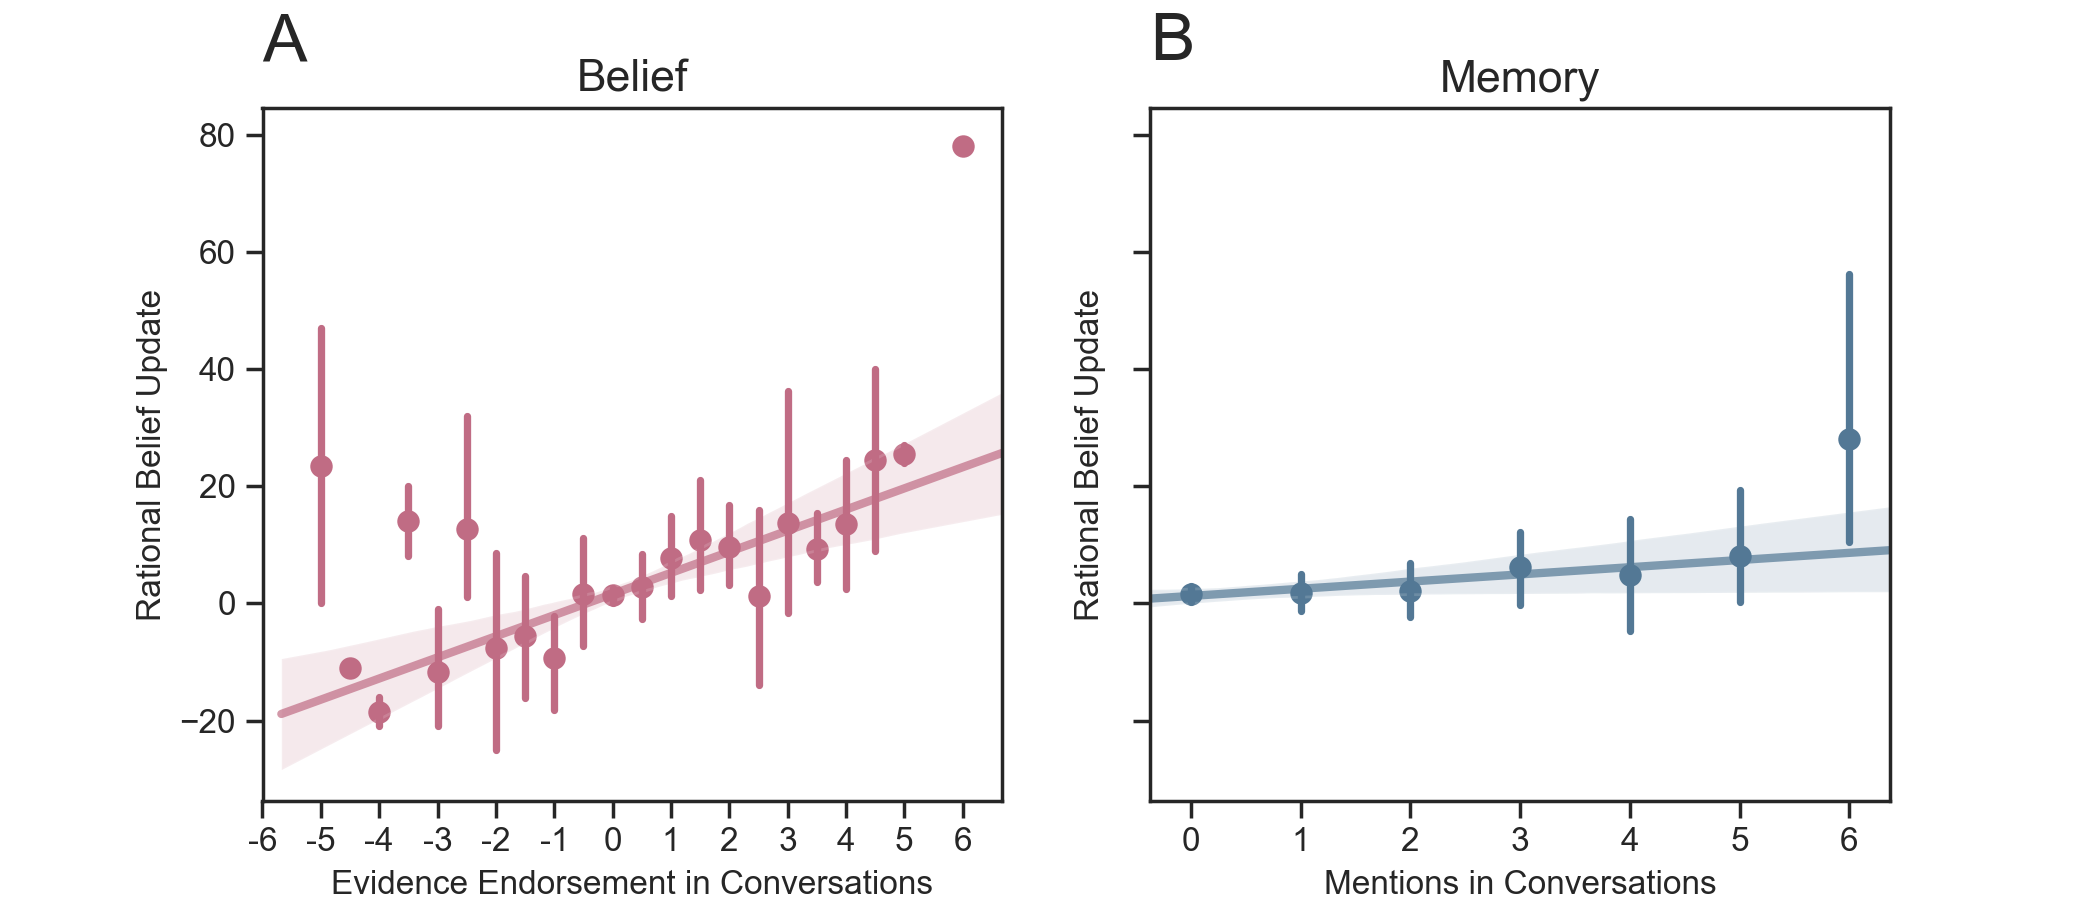

In [7]:
fig, ax = plt.subplots(1,2, figsize=(10.5,4.5), sharey=True)

#plt.scatter(beleif, RdeltaB)
sns.regplot(x=DATA["jointB"], y=DATA["RdeltaB"], scatter_kws={"color": "#C06C84"}, line_kws={"color":"#C06C84","alpha":0.7,"lw":3}, x_estimator=np.mean, ax=ax[0])
ax[0].set_xlabel("Evidence Endorsement in Conversations")
ax[0].set_ylabel("Rational Belief Update")
ax[0].set_xticks([2*i for i in [-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6]])
ax[0].set_xticklabels([-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6])
# plt.xticks(ticks=[2*i for i in [-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6]], labels=[-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6])
ax[0].set_title("Belief", fontsize = 16)
bff.panellabel(ax[0], "A")


#plt.scatter(recall, RdeltaB)
sns.regplot(x=DATA["jointM"], y=DATA["RdeltaB"], scatter_kws={"color": "#537895"}, line_kws={"color":"#537895","alpha":0.7,"lw":3}, x_estimator=np.mean, ax=ax[1])
ax[1].set_xlabel("Mentions in Conversations")
ax[1].set_ylabel("Rational Belief Update", labelpad=16)
ax[1].set_title("Memory", fontsize = 16)
bff.panellabel(ax[1], "B")


plt.savefig('fig4.tif', dpi=900, format="tiff")
plt.show()

# R

In [10]:
%load_ext rpy2.ipython
# %R library(lme4)

#import warnings
#warnings.filterwarnings('ignore')

In [ ]:
%R library(lmerTest)

In [15]:
%Rpush DATA

/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [40]:
%%R

M <- lmer(RdeltaB ~ -1 + jointM + jointB + (1 | partnum) + (1 | network), data = DATA)
print(summary(M))

#rfs <- ranef(M)$participant
#ffs <- fixef(M)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: RdeltaB ~ -1 + jointM + jointB + (1 | partnum) + (1 | network)
   Data: DATA

REML criterion at convergence: 9925

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.8093 -0.4243  0.0130  0.4817  4.1306 

Random effects:
 Groups   Name        Variance Std.Dev.
 partnum  (Intercept)  15.37    3.921  
 network  (Intercept)   0.00    0.000  
 Residual             400.26   20.007  
Number of obs: 1120, groups:  partnum, 140; network, 14

Fixed effects:
        Estimate Std. Error        df t value Pr(>|t|)    
jointM    0.9201     0.4918  950.5268   1.871   0.0617 .  
jointB    1.7378     0.3516 1099.1868   4.942 8.93e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
       jointM
jointB -0.287
convergence code: 0
boundary (singular) fit: see ?isSingular



## Network convergence v1: Change in (rank) correlation from pre to post

In [9]:
nbin = 20
clustered = np.array([1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0], dtype=np.int)

## PRE
corrs_pre = list()
for i in range(max(df["NETWORK"])):
    net = np.array(df.loc[df["NETWORK"]==i+1, "PRE1":"PRE8"])
    corrs_pre += [stats.spearmanr(net.T).correlation]
corrs_pre = np.stack(corrs_pre, axis=0)
## POST
corrs_post = list()
for i in range(max(df["NETWORK"])):
    net = np.array(df.loc[df["NETWORK"]==i+1, "POST1":"POST8"])
    corrs_post += [stats.spearmanr(net.T).correlation]
corrs_post = np.stack(corrs_post, axis=0)

## POST-PRE
cdiff = (corrs_post - corrs_pre) / 2
cdiff_clustered = np.mean(cdiff[clustered==1,:,:], axis=0)
cdiff_nonclustered = np.mean(cdiff[clustered==0,:,:], axis=0)

In [10]:
## Hypothesis matrices
H_clustered = np.array(
    [[0,1,1,1,2,3,4,4,5,5],
     [1,0,1,1,2,3,4,4,5,5],
     [1,1,0,2,1,2,3,3,4,4],
     [1,1,2,0,1,2,3,3,4,4],
     [2,2,1,1,0,1,2,2,3,3],
     [3,3,2,2,1,0,1,1,2,2],
     [4,4,3,3,2,1,0,2,1,1],
     [4,4,3,3,2,1,2,0,1,1],
     [5,5,4,4,3,2,1,1,0,1],
     [5,5,4,4,3,2,1,1,1,0]])
H_nonclustered = np.array(
    [[0,2,1,1,2,3,2,2,1,3],
     [2,0,1,1,2,3,2,2,3,1],
     [1,1,0,2,1,2,3,3,2,2],
     [1,1,2,0,1,2,3,3,2,2],
     [2,2,1,1,0,1,2,2,3,3],
     [3,3,2,2,1,0,1,1,2,2],
     [2,2,3,3,2,1,0,2,1,1],
     [2,2,3,3,2,1,2,0,1,1],
     [1,3,2,2,3,2,1,1,0,2],
     [3,1,2,2,3,2,1,1,2,0]])

<IPython.core.display.Javascript object>


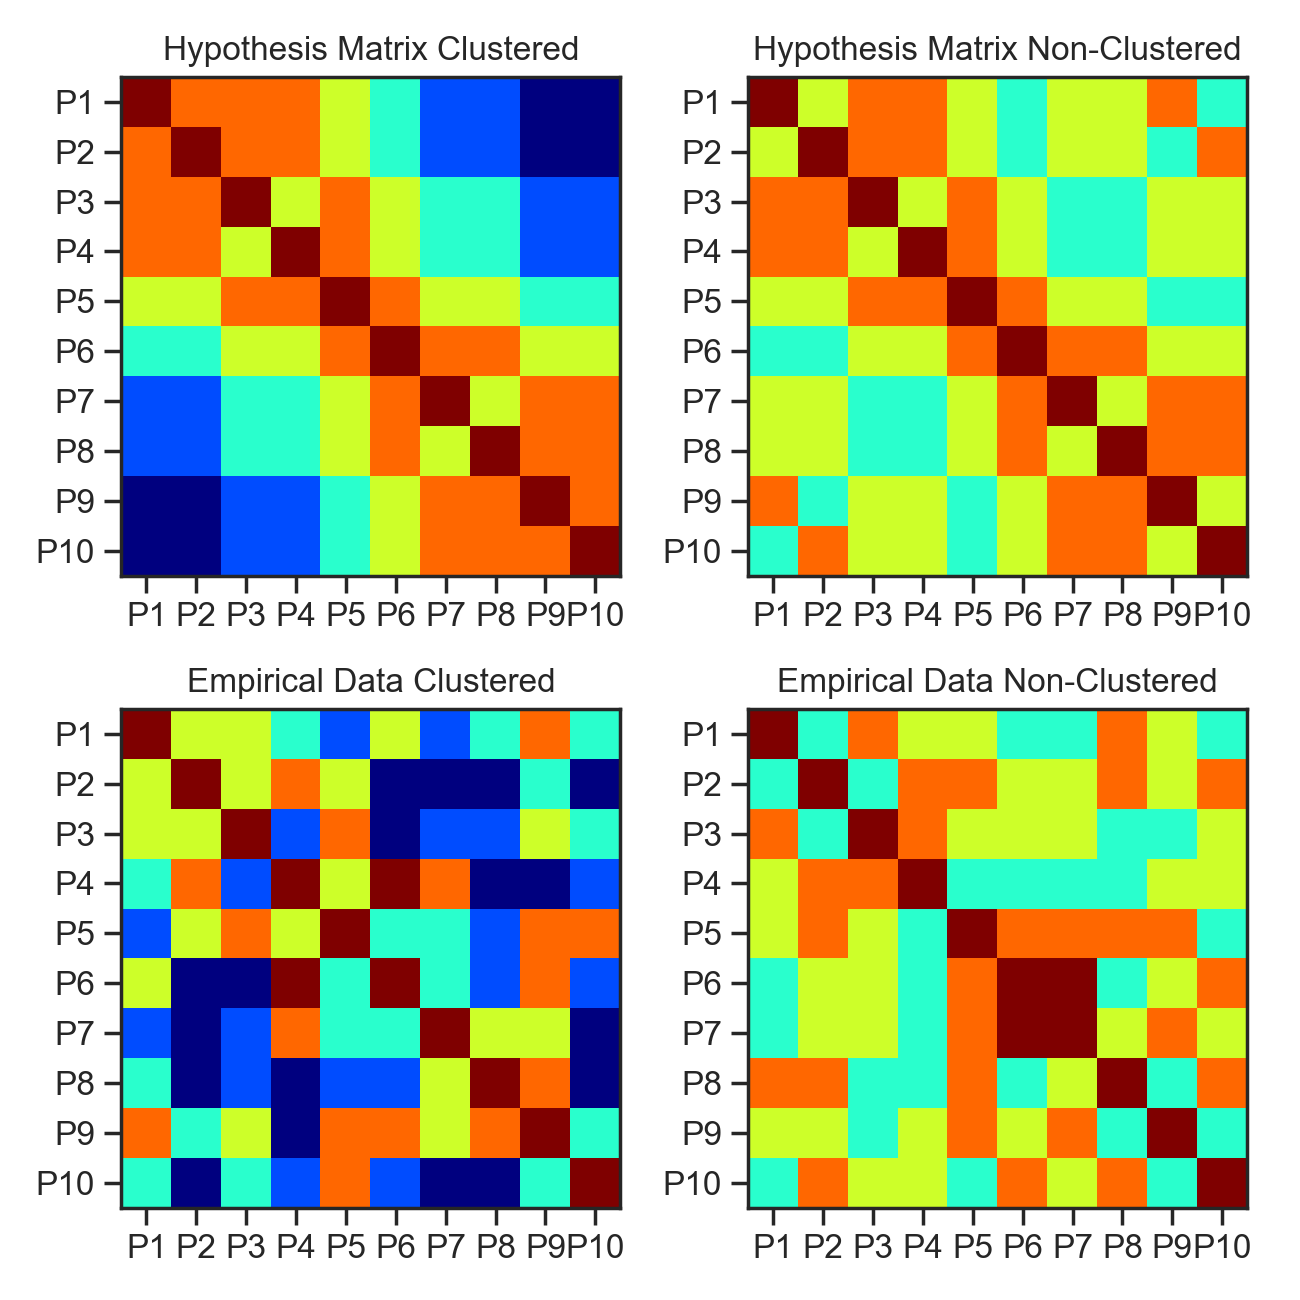

In [12]:
fig, ax = plt.subplots(2,2, figsize=(6.5,6.5))
ax[0,0].imshow(H_clustered, cmap="jet_r", clim=[0,5])
ax[0,0].grid(b=None, which='minor', axis='both')
ax[0,0].set_xticks(np.arange(0,10,1)); ax[0,0].set_xticklabels(['P1','P2','P3','P4','P5','P6','P7','P8','P9','P10']);
ax[0,0].set_yticks(np.arange(0,10,1)); ax[0,0].set_yticklabels(['P1','P2','P3','P4','P5','P6','P7','P8','P9','P10']);
ax[0,0].set_title("Hypothesis Matrix Clustered")

cdiff_clustered_forplotting = np.digitize(cdiff_clustered, np.quantile(cdiff_clustered[iu], np.linspace(1,0,6)))
cdiff_clustered_forplotting -= int(cdiff_clustered_forplotting[0,0])*np.eye(cdiff_clustered_forplotting.shape[0], dtype=np.int)
ax[1,0].imshow(cdiff_clustered_forplotting, cmap="jet_r", clim=[0,5])
ax[1,0].set_xticks(np.arange(0,10,1)); ax[1,0].set_xticklabels(['P1','P2','P3','P4','P5','P6','P7','P8','P9','P10']);
ax[1,0].set_yticks(np.arange(0,10,1)); ax[1,0].set_yticklabels(['P1','P2','P3','P4','P5','P6','P7','P8','P9','P10']);
ax[1,0].set_title("Empirical Data Clustered")

ax[0,1].imshow(H_nonclustered, cmap="jet_r", clim=[0,5])
ax[0,1].grid(b=None, which='minor', axis='both')
ax[0,1].set_xticks(np.arange(0,10,1)); ax[0,1].set_xticklabels(['P1','P2','P3','P4','P5','P6','P7','P8','P9','P10']);
ax[0,1].set_yticks(np.arange(0,10,1)); ax[0,1].set_yticklabels(['P1','P2','P3','P4','P5','P6','P7','P8','P9','P10']);
ax[0,1].set_title("Hypothesis Matrix Non-Clustered")

cdiff_nonclustered_forplotting = np.digitize(cdiff_nonclustered, np.quantile(cdiff_nonclustered[iu], np.linspace(1,0,4)))
cdiff_nonclustered_forplotting -= int(cdiff_nonclustered_forplotting[0,0])*np.eye(cdiff_nonclustered_forplotting.shape[0], dtype=np.int)
ax[1,1].imshow(cdiff_nonclustered_forplotting, cmap="jet_r", clim=[0,5])
ax[1,1].set_xticks(np.arange(0,10,1)); ax[1,1].set_xticklabels(['P1','P2','P3','P4','P5','P6','P7','P8','P9','P10']);
ax[1,1].set_yticks(np.arange(0,10,1)); ax[1,1].set_yticklabels(['P1','P2','P3','P4','P5','P6','P7','P8','P9','P10']);
ax[1,1].set_title("Empirical Data Non-Clustered")


plt.tight_layout()
#ax[2,0].scatter(H_clustered.reshape(-1), cdiff_clustered.reshape(-1))
#ax[2,1].scatter(H_nonclustered.reshape(-1), cdiff_nonclustered.reshape(-1))

plt.savefig('correl.tif', dpi=300, format="tiff")


In [15]:
iu = np.triu_indices(cdiff_clustered.shape[0], 1)
def shuffle_bootstrap(conv, H, NBOOT=10000):
    map_dict = {i+1: q for i,q in enumerate(np.quantile(conv[iu], np.linspace(0,1,np.max(H))))}
    map_dict[0] = np.nan
    mapper = np.vectorize(lambda x: map_dict[x])
    sim = mapper(H)
    
    r_boot = np.zeros(NBOOT)
    for i in range(NBOOT):
        perm = np.random.permutation(np.arange(10))
        shuffled = sim[perm[:,None], perm]
        r_boot[i] = stats.pearsonr(shuffled[iu], conv[iu])[0]

    r_obs = stats.pearsonr(sim[iu], conv[iu])[0]
    p = np.sum(np.less(r_boot, r_obs)) / NBOOT
    return p, r_obs, r_boot

clustmatch       = shuffle_bootstrap(cdiff_clustered, H_clustered)
clustmismatch    = shuffle_bootstrap(cdiff_clustered, H_nonclustered)
nonclustmatch    = shuffle_bootstrap(cdiff_nonclustered, H_nonclustered)
nonclustmismatch = shuffle_bootstrap(cdiff_nonclustered, H_clustered)

In [16]:
d = 3
N = 10
def random_network(d=3, N=10):
    ## Generate random d-regular graph on N nodes
    G = nx.random_regular_graph(d, N)
    ## Get shortest path between all pairs of nodes
    path = np.array([len(nx.dijkstra_path(G, i, j))-1 for i in range(1,N) for j in range(i)])
    ## Insert into matrix of shortest paths
    D = np.zeros((N,N))
    D[np.tril_indices(N, -1)] = path
    D += D.T
    return D
## Visualize graph with labeled nodes
# plt.figure()
# pos = nx.spring_layout(G)
# nx.draw(G, pos=pos)
# nx.draw_networkx_labels(G, pos=pos)

iu = np.triu_indices(N, 1)
def full_bootstrap(conv, Htrue, NBOOT=10000):
    r_boot = np.zeros(NBOOT)
    for i in range(NBOOT):
        try:
            H = random_network()
            map_dict = {i+1: q for i,q in enumerate(np.quantile(conv[iu], np.linspace(0,1,np.max(H))))}
            map_dict[0] = np.nan
            mapper = np.vectorize(lambda x: map_dict[x])
            sim = mapper(H)
#             r_boot[i] = stats.pearsonr(sim[iu], conv[iu])[0]
            r_boot[i] = stats.spearmanr(sim[iu], conv[iu])[0]
        except:
            i -= 1

    map_dict = {i+1: q for i,q in enumerate(np.quantile(conv[iu], np.linspace(0,1,np.max(Htrue))))}
    map_dict[0] = np.nan
    mapper = np.vectorize(lambda x: map_dict[x])
    sim = mapper(Htrue)
#     r_obs = stats.pearsonr(sim[iu], conv[iu])[0]
    r_obs = stats.spearmanr(sim[iu], conv[iu])[0]
    p = np.sum(np.less(r_boot, r_obs)) / NBOOT
    return p, r_obs, r_boot

clustered    = full_bootstrap(cdiff_clustered, H_clustered)
nonclustered = full_bootstrap(cdiff_nonclustered, H_nonclustered)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


<IPython.core.display.Javascript object>


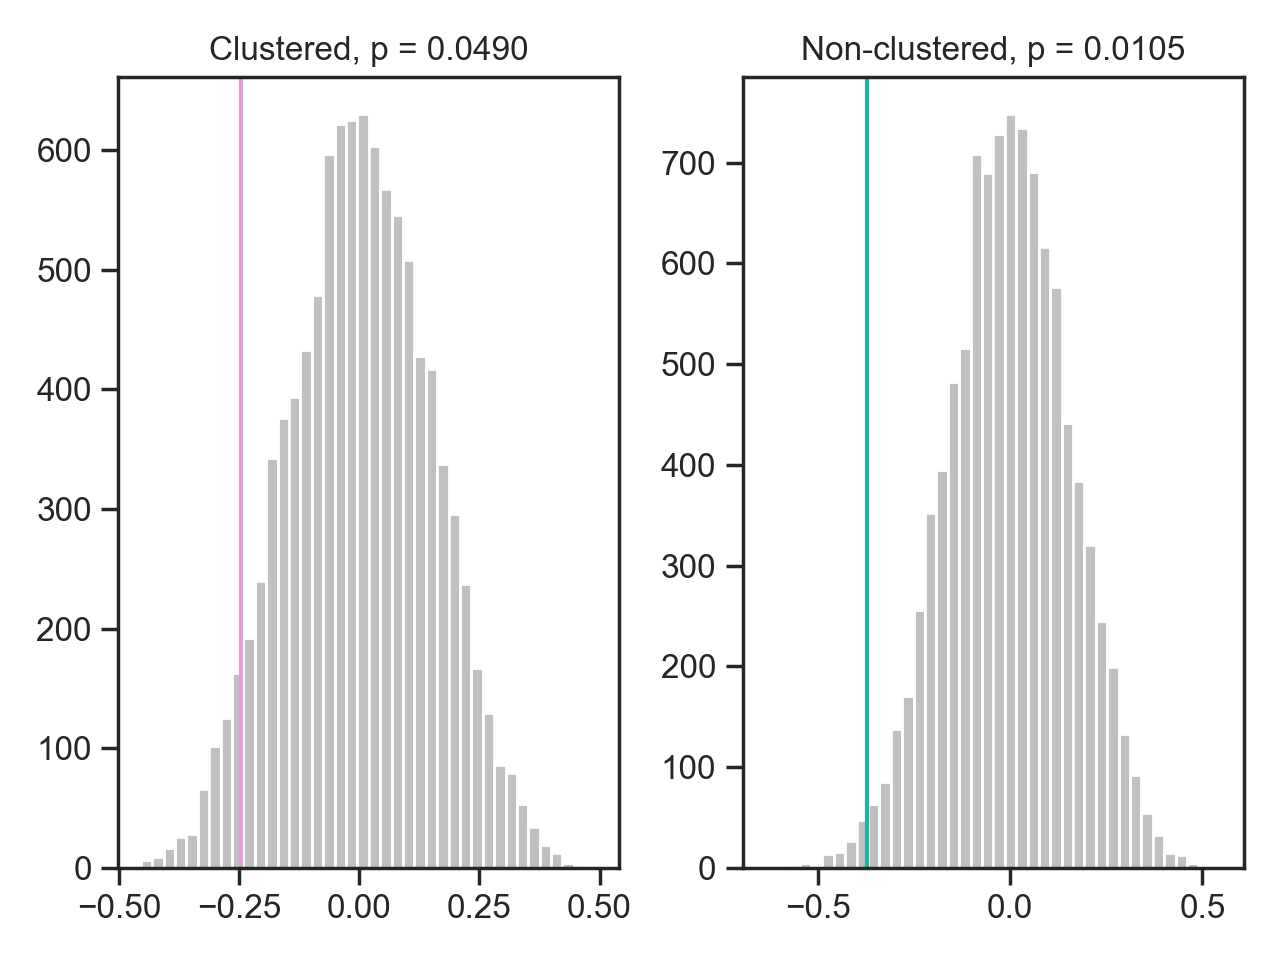

In [17]:
fig, ax = plt.subplots(1,2)

ax[0].hist(clustered[-1], bins=40, color="#c0c0c0")
ax[0].axvline(clustered[1], color="#DDA0DD")
ax[0].set_title("Clustered, p = %.4f" % clustered[0])

ax[1].hist(nonclustered[-1], bins=40, color="#c0c0c0")
ax[1].axvline(nonclustered[1], color="#20B2AA")
ax[1].set_title("Non-clustered, p = %.4f" % nonclustered[0])

plt.tight_layout()
plt.savefig('hist.tif', dpi=300, format="tiff")


<IPython.core.display.Javascript object>


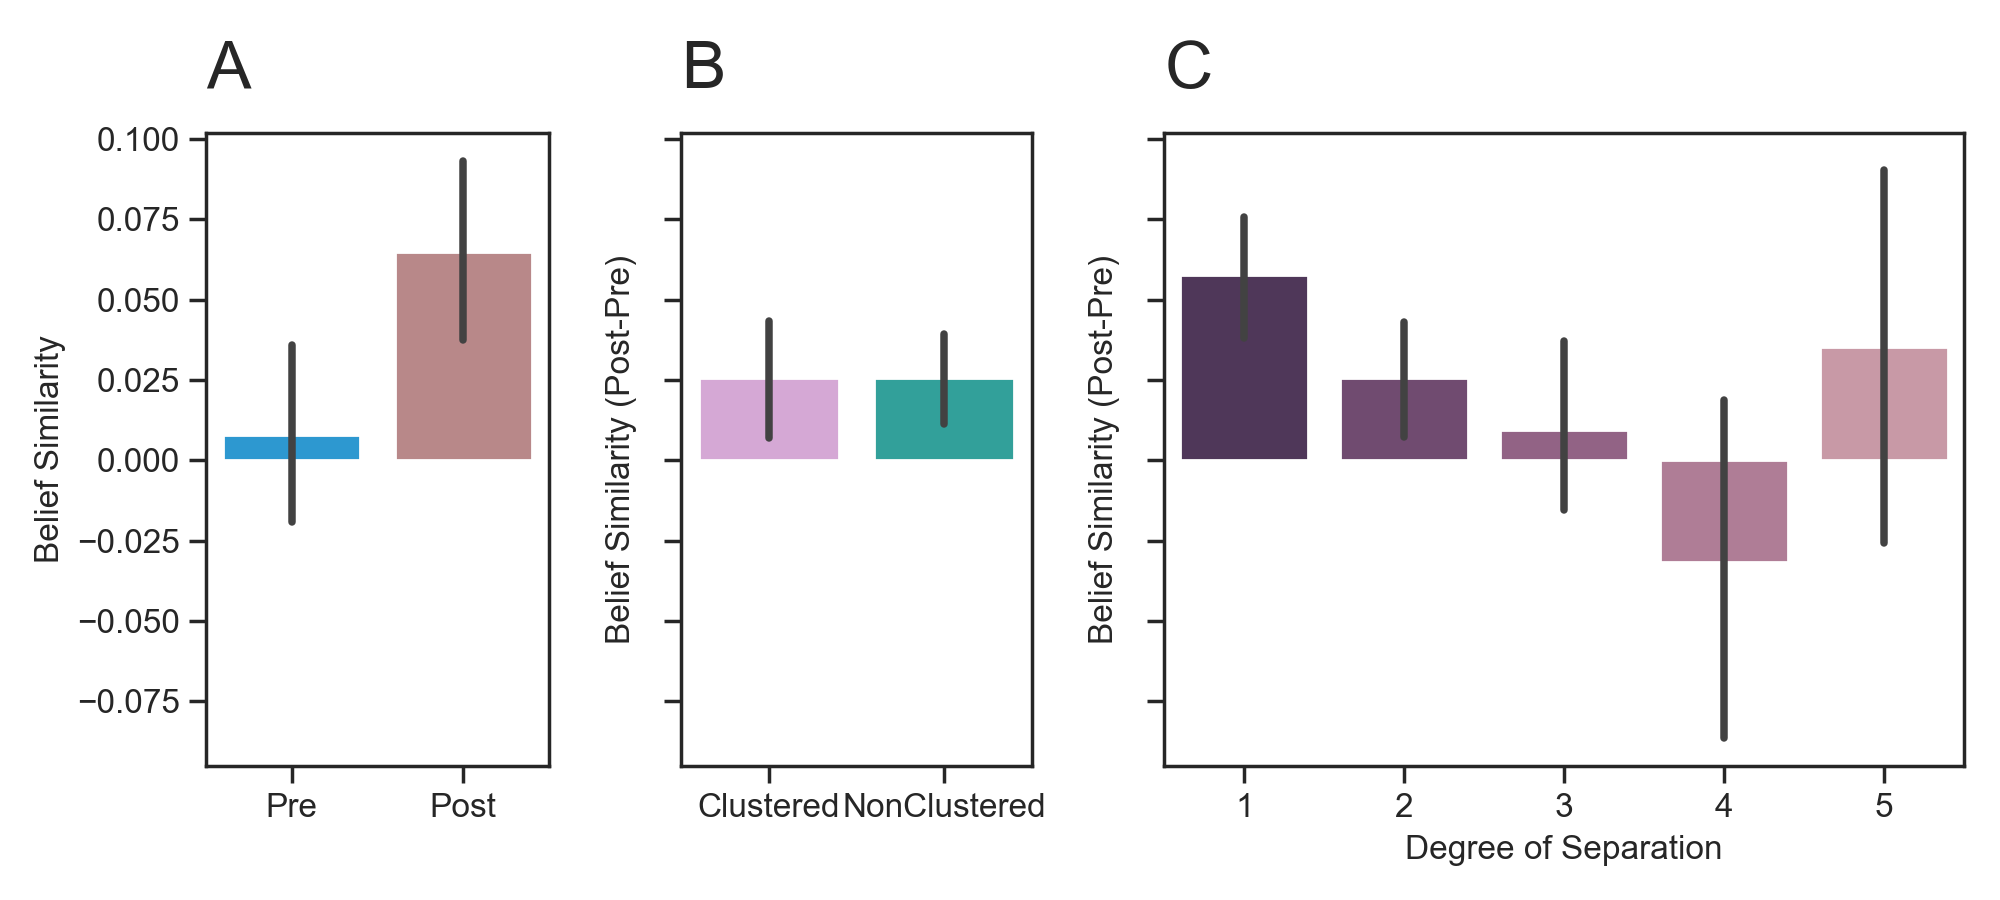

In [19]:
nbin = 20
palll=sns.cubehelix_palette(8, reverse=True)

## PRE
corrs_pre = np.array([])
for i in range(max(df["NETWORK"])):
    net = np.array(df.loc[df["NETWORK"]==i+1, "PRE1":"PRE8"])
    iu = np.triu_indices(net.shape[0], 1)
#     corrs_pre = np.append(corrs_pre, np.corrcoef(net)[iu])
    corrs_pre = np.append(corrs_pre, stats.spearmanr(net.T).correlation[iu])

## POST
corrs_post = np.array([])
for i in range(max(df["NETWORK"])):
    net = np.array(df.loc[df["NETWORK"]==i+1, "POST1":"POST8"])
    iu = np.triu_indices(net.shape[0], 1)
#     corrs_post = np.append(corrs_post, np.corrcoef(net)[iu])
    corrs_post = np.append(corrs_post, stats.spearmanr(net.T).correlation[iu])
    
    
fig, ax = plt.subplots(1,3, figsize=(10,4.5), gridspec_kw={"width_ratios": [0.9,0.92,2.1]}, sharey=True)
    
xx = np.hstack([np.ones(corrs_pre.shape), 1+np.ones(corrs_post.shape)])
yy = np.hstack([corrs_pre, corrs_post])
pp = ["#12a1eb","#c08081"]
sns.barplot(xx, yy, palette=pp, ax=ax[0])
ax[0].set_xticklabels(["Pre","Post"])
ax[0].set_ylabel('Belief Similarity')
#ax[0].set_ylim([-0.03,0.11])
bff.panellabel(ax[0], "A")


xxx = np.hstack([np.ones(cdiff_clustered.reshape(-1).shape), 1+np.ones(cdiff_nonclustered.reshape(-1).shape)])
yyy = np.hstack([cdiff_clustered.reshape(-1), cdiff_nonclustered.reshape(-1)])
p = ["#DDA0DD", "#20B2AA"]
sns.barplot(pd.Series(xxx), pd.Series(yyy), palette=p, ax=ax[1])
ax[1].set_xticklabels(["Clustered","NonClustered"])
ax[1].set_ylabel('Belief Similarity (Post-Pre)', labelpad=16)
#ax[1].set_ylim([0,0.055])
bff.panellabel(ax[1], "B")


H_both = np.concatenate((H_clustered.reshape(-1), H_nonclustered.reshape(-1)))
cdiff_both = np.concatenate((cdiff_clustered.reshape(-1), cdiff_nonclustered.reshape(-1)))
sns.barplot(pd.Series(H_both), pd.Series(cdiff_both), palette=palll, ax=ax[2])
ax[2].set(xlabel='Degree of Separation')
ax[2].set_xlim([0.5,5.5])
ax[2].set_ylabel('Belief Similarity (Post-Pre)', labelpad=16)
#ax[2].set_ylim([-0.09,0.09])
bff.panellabel(ax[2], "C")

plt.tight_layout()
plt.savefig('Fig3.tif', dpi=900, format="tiff")